## Boilerplate

In [1]:
import sys
import subprocess
import os

if 'google.colab' in sys.modules:
    print("Running on Colab")

    # Clone repo using subprocess to run shell command inside if block
    subprocess.run([
        #'git', 'clone', '--recurse-submodules',
        'git', 'clone',
        'https://github.com/walligot/don_thesis.git'
    ])

    # Change directory
    os.chdir('/content/don_thesis')
    #%pip install -e ./DSA
   # %pip install git+https://github.com/ahwillia/netrep.git
    %pip install git+https://github.com/mitchellostrow/DSA.git

    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['HOME'] = '/content/drive/MyDrive/Thesis'
    ROOT_PATH = '/content/don_thesis'
    os.environ['ROOT_PATH'] = ROOT_PATH

else:
    %pip install git+https://github.com/mitchellostrow/DSA.git

    from pathlib import Path

    current_path = Path().resolve()

    ROOT_PATH = None
    for parent in [current_path] + list(current_path.parents):
        if "don_thesis" in parent.name.lower():
            ROOT_PATH = parent
            os.environ['ROOT_PATH'] = str(ROOT_PATH)
            break

    if not ROOT_PATH:
        raise FileNotFoundError("Directory with name 'don_thesis' not found.")

    print("Running locally or elsewhere")

print(f"Root path: {ROOT_PATH}")


Running on Colab
  Cloning https://github.com/mitchellostrow/DSA.git to /tmp/pip-req-build-rc6bc2rd
  Running command git clone --filter=blob:none --quiet https://github.com/mitchellostrow/DSA.git /tmp/pip-req-build-rc6bc2rd
  Resolved https://github.com/mitchellostrow/DSA.git to commit a46c3194eb1f736db31e7eca5f433839c2cbc311
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.8 MB/s eta 0:

## Code Definitions

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
import numpy as np
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
N = 100  # number of RNN units
dt = 0.15  # time step
T_train = 300  # shorter training sequence length
T_eval = 1000  # evaluation sequence length
#n_bits = 3  # 3-bit memory
pulse_prob = 0.01  # probability of pulse per bit per timestep
noise_std = 0.015  # standard deviation of noise added to hidden state during training

# Define the RNN dynamics class
class ContinuousRNN(nn.Module):
    def __init__(self, N, n_bits, device=device):
        super(ContinuousRNN, self).__init__()
        self.device = device or torch.device('cpu')
        self.N = N
        self.n_bits = n_bits
        self.input_weights = nn.Parameter(torch.randn(N, n_bits) * 0.1)
        self.recurrent_weights = nn.Parameter(torch.randn(N, N) * 0.1 * 1.0)
        self.output_weights = nn.Parameter(torch.randn(n_bits, N) * 0.1)
        self.nonlinearity = torch.tanh
        self.to(self.device)

    def forward(self, inputs, return_h=False, add_noise=False):
      # Move inputs to self.device if not already
        if inputs.device != self.device:
            inputs = inputs.to(self.device)

        batch_size, seq_len, _ = inputs.shape
        h = torch.zeros(batch_size, self.N, device=self.device)
        outputs = []
        hidden_states = []

        #print(self.device)
        #print(self.input_weights.device)
        #print(self.recurrent_weights.device)
        #print(self.output_weights.device)
        #print(inputs.device)
        #print(h.device)

        for t in range(seq_len):
            input_t = inputs[:, t, :]
            dh = (-h + self.nonlinearity(
                torch.matmul(h, self.recurrent_weights.T) + torch.matmul(input_t, self.input_weights.T)
            )) * dt
            if add_noise:
                dh += torch.randn_like(h) * noise_std
            h = h + dh
            out = torch.matmul(h, self.output_weights.T)
            outputs.append(out)
            hidden_states.append(h)

        outputs = torch.stack(outputs, dim=1)
        hidden_states = torch.stack(hidden_states, dim=1)

        if return_h:
            return outputs, hidden_states
        else:
            return outputs

def generate_batch(batch_size, T, n_bits, pulse_prob, device='cpu'):
    inputs = torch.zeros(batch_size, T, n_bits, device=device)
    targets = torch.zeros(batch_size, T, n_bits, device=device)

    # Current state per bit per sample
    current_input = torch.zeros(batch_size, n_bits, device=device)
    memory = torch.zeros(batch_size, n_bits, device=device)

    for t in range(T):
        # Decide which bits start a new pulse
        start_mask = (current_input == 0) & (torch.rand(batch_size, n_bits, device=device) < pulse_prob)

        # Random ±1 for new pulses
        new_pulses = (torch.randint(0, 2, (batch_size, n_bits), device=device) * 2 - 1).float()

        # Apply new pulses
        current_input[start_mask] = new_pulses[start_mask]
        memory[start_mask] = current_input[start_mask]  # update memory only on new pulses

        # Decide which bits return to 0
        stop_mask = (current_input != 0) & (torch.rand(batch_size, n_bits, device=device) < 0.05)
        current_input[stop_mask] = 0.0

        # Store values
        inputs[:, t, :] = current_input
        targets[:, t, :] = memory

    return inputs, targets

def save_rnn_model(model, path):
    torch.save({
        'N': model.N,
        'n_bits': model.n_bits,
        'state_dict': model.state_dict()
    }, path)

def load_rnn(save_path, device=device):
    """
    Loads a ContinuousRNN from disk, reconstructing it completely.
    Returns the model in eval() mode.

    Args:
      save_path (str): path to .pth file saved by save_rnn.
      device (torch.device or str, optional): where to load the weights;
        if None, defaults to CPU.
    """
    # 1) Load checkpoint
    device = device or torch.device('cpu')
    ckpt = torch.load(save_path, map_location=device)

    # 2) Reconstruct a fresh model
    loaded_rnn = ContinuousRNN(N=ckpt['N'], n_bits=ckpt['n_bits'], device=device)

    # 3) Load the weights
    loaded_rnn.load_state_dict(ckpt['state_dict'])

    # 4) Eval mode
    loaded_rnn.eval()

    print(f"Loaded ContinuousRNN (N={ckpt['N']}, n_bits={ckpt['n_bits']}) from '{save_path}'")
    return loaded_rnn

def randomise_rnn_old(orig_rnn, reinit_input=False, reinit_rec=False, reinit_output=False, scale=0.1):
    # 1) Deep‐copy the whole model (so you don’t clobber the original)
    new_rnn = copy.deepcopy(orig_rnn)

    # 2) Reinitialize the selected Parameter tensors in-place
    with torch.no_grad():
        if reinit_input:
            new_rnn.input_weights.copy_(torch.randn_like(new_rnn.input_weights) * scale)
        if reinit_rec:
            new_rnn.recurrent_weights.copy_(torch.randn_like(new_rnn.recurrent_weights) * scale)
        if reinit_output:
            new_rnn.output_weights.copy_(torch.randn_like(new_rnn.output_weights) * scale)
    return new_rnn

def randomise_rnn(orig_rnn, reinit_input=False, reinit_rec=False, reinit_output=False, scale=0.1):
    # 1) Create a new instance of the model with the same parameters
    new_rnn = type(orig_rnn)(orig_rnn.N, orig_rnn.n_bits, device=orig_rnn.input_weights.device)

    # 2) Load a deepcopy of the state_dict to the new model
    new_rnn.load_state_dict(copy.deepcopy(orig_rnn.state_dict()))

    # 3) Reinitialize the selected Parameter tensors in-place
    with torch.no_grad():
        if reinit_input:
            new_rnn.input_weights.copy_(torch.randn_like(new_rnn.input_weights) * scale)
        if reinit_rec:
            new_rnn.recurrent_weights.copy_(torch.randn_like(new_rnn.recurrent_weights) * scale)
        if reinit_output:
            new_rnn.output_weights.copy_(torch.randn_like(new_rnn.output_weights) * scale)
    return new_rnn

def eval_rnn_specific(rnn, inputs, targets, plot=False):
    # Evaluate on longer sequence
    n_bits = rnn.n_bits
    loss_fn = nn.MSELoss()
    #inputs, targets = generate_batch(1, T_eval, n_bits, pulse_prob)
    outputs, hidden_states = rnn(inputs, return_h=True)
    hidden_states = hidden_states.squeeze(0).detach().cpu().numpy()

    if plot:
        with torch.no_grad():
            loss = loss_fn(outputs[:T_train], targets[:T_train])
            predicted_sign = torch.sign(outputs[:T_train])
            target_sign = torch.sign(targets[:T_train])
            acc = (predicted_sign == target_sign).float().mean()
            print(f"Evaluation Loss: {loss.item():.5f}, Sign Acc: {acc.item() * 100:.2f}%")

        plt.figure(figsize=(15, 8))
        for i in range(n_bits):
            plt.subplot(n_bits, 1, i+1)
            plt.plot(inputs[0, :, i], label="Input", linestyle=':', alpha=0.5)
            plt.plot(targets[0, :, i], label="Target", linestyle='-', alpha=0.9)
            #plt.plot(outputs[:, i], label="Output", linestyle='--', alpha=0.9)
            plt.plot(outputs.squeeze(0).detach().cpu().numpy()[:, i], label='Output', linestyle='--', alpha =0.9)
            plt.legend()
            plt.title(f'Bit {i+1}')
        plt.tight_layout()
        plt.show()

    return hidden_states

Using device: cpu


In [3]:
#save_rnn_model(twobitallrandom, os.path.join(home, 'Models', 'twobitallrandom.pth'))#

In [4]:
import torch
import itertools
import numpy as np
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def get_flip_inputs(device, T=1000, pulse_t=150, k=3, n_bits=3):
    # --- 1) Generate all single‐bit flip trajectories ---
    #flip_trajectories = []
    # all 8 memory patterns
    input_list = []

    for pattern in itertools.product([-1.0, 1.0], repeat=n_bits):
        base = torch.tensor(pattern, device=device).view(1, n_bits)
        for bit in range(n_bits):
            # build inputs: start at `base`, no input until the flip, then flip that bit
            inputs = torch.zeros(1, T, n_bits, device=device)
            inputs[0, 0, :] = base
            inputs[0, pulse_t, bit] = -base[0, bit]
            input_list.append(inputs)
            # run RNN
            #outputs, hs = rnn(inputs, return_h=True)   # hs: (1, T, N)
            #hs = hs.squeeze(0).detach()                # (T, N)

            #flip_trajectories.append({
            #    'pattern': pattern,
            #    'bit': bit,
            #    'hidden': hs
            #})
            #flip_trajectories.append(hs)

        init_indices = [pulse_t - 1, pulse_t + 1, T - 1]

    return input_list, init_indices

def get_perimeter_input(transitions=None, T_per=300, pulse_width=5 , pulse_offset=50, T_buffer=100, n_bits=2, device=device):
    assert n_bits == 2, "Only 2-bit states supported."

    # States to traverse: one bit changes per step
    if transitions is None:
        transitions = [
            [+1, +1],  # initial state
            [-1, +1],
            [-1, -1],
            [+1, -1],
            [+1, +1]   # close the loop
        ]

    num_transitions = len(transitions) - 1
    T_total = T_buffer + T_per * (num_transitions + 1)  # extra segment for initialisation
    inputs = torch.zeros(1, T_total, n_bits, device=device)
    targets = torch.zeros(1, T_total, n_bits, device=device)
    init_indices = []

    # === 1) Initial pulse to (+1, +1) ===
    t_start = T_buffer
    t_pulse = t_start + pulse_offset
    inputs[0, t_pulse : t_pulse + pulse_width, :] = +1  # pulse both bits ON
    targets[0, t_start : t_start + T_per, :] = torch.tensor([+1, +1], device=device)

    init_indices.extend([t_pulse - 1, t_pulse + 1, t_start + T_per - 1])

    # === 2) Traverse perimeter ===
    for i in range(num_transitions):
        curr = torch.tensor(transitions[i], device=device)
        next_ = torch.tensor(transitions[i + 1], device=device)
        flip_bit = (curr != next_).nonzero(as_tuple=True)[0].item()

        t_start = T_buffer + T_per * (i + 1)
        t_pulse = t_start + pulse_offset
        t_late = t_start + T_per - 1

        inputs[0, t_pulse : t_pulse + pulse_width, flip_bit] = -curr[flip_bit]
        targets[0, t_start : t_start + T_per, :] = next_

        init_indices.extend([t_pulse - 1, t_pulse + 1, t_late])

    return torch.cat([inputs], dim=0)  , init_indices, targets

def get_hidden_states(rnn, input_list, burn_in=0, add_noise=False, pca_dim=None, smooth=False, sigma=1, squeeze=True):
    """
    Gets hidden states from an RNN and optionally applies PCA and smoothing.

    Parameters
    ----------
    rnn : torch.nn.Module
        RNN model with return_h=True support.
    input_list : torch.Tensor or list of tensors
        Input sequence(s) to the RNN.
    add_noise : bool, default=False
        Whether to enable noise during the forward pass.
    pca_dim : int or None, default=None
        If not None, apply PCA with this number of components.
    smooth : bool, default=False
        If True, apply Gaussian smoothing to the PCA output.
    sigma : float, default=1
        Standard deviation for the Gaussian filter.
    squeeze : bool, default=True
        If True, remove the batch dimension from the output.

    Returns
    -------
    hidden_states : np.ndarray
        The raw hidden states if pca_dim is None, or PCA-projected (and optionally smoothed) data.
    """

    with torch.no_grad():
        _, hs = rnn(input_list, return_h=True, add_noise=add_noise)
        orig_device = hs.device
        orig_dtype = hs.dtype
        if squeeze:
            hs = hs.squeeze(0)
        hs = hs.detach().cpu().numpy()  # shape: (T, N)
        hs = hs[burn_in:]

    if pca_dim is not None:
        pca = PCA(n_components=pca_dim)
        hs = pca.fit_transform(hs)
        if smooth:
            hs = gaussian_filter1d(hs, sigma=sigma, axis=0)

    hs = torch.tensor(hs, dtype=orig_dtype, device=orig_device)

    return hs

def pca_with_smoothing(hidden_states, pca_dim=2, smooth=False, sigma=1):
    orig_device = hidden_states.device
    orig_dtype = hidden_states.dtype
    hidden_states = hidden_states.cpu().numpy()

    pca = PCA(n_components=pca_dim)
    h_pca = pca.fit_transform(hidden_states)
    if smooth:
        h_pca = gaussian_filter(h_pca, sigma=sigma)

    h_pca = torch.tensor(h_pca, dtype=orig_dtype, device=orig_device)

    return h_pca

def find_fixed_points(rnn, hidden_states, init_indices, T=1000, pulse_t=150, k=3, n_bits=3):
    # --- PARAMETERS ---
    #T = 1000                # sequence length
    #pulse_t = 150      # time of the bit‐flip pulse
    #k = 3                  # number of samples per trajectory: before, after, end
    #n_bits = 3
    device = next(rnn.parameters()).device

    # --- 2) Sample k=3 points from each trajectory ---
    #init_points = []   # list of torch.Tensor shape (1, N)
    #for traj in flip_trajectories:
    #for hs in hidden_states:
        #hs = traj
        #times = [pulse_t - 1, pulse_t + 1, T - 1]  # just before, just after, end
    #    for t in init_indices:
    #        init_points.append(hs[t].view(1, -1))
    init_points = hidden_states[init_indices]

    def find_fixed_point(rnn, h_init, input_t=None, n_iters=500, lr=1e-2):
        h = h_init.clone().detach().to(rnn.input_weights.device).requires_grad_(True)
        optimizer = torch.optim.Adam([h], lr=lr)

        for _ in range(n_iters):
            optimizer.zero_grad()
            input_effective = torch.zeros(1, rnn.n_bits, device=h.device) if input_t is None else input_t
            dh = (-h + torch.tanh(h @ rnn.recurrent_weights.T + input_effective @ rnn.input_weights.T)) * dt
            loss = torch.norm(dh)
            loss.backward()
            optimizer.step()

        return h.detach()

    fixed_points = []
    for h_init in tqdm(init_points):
        #fp = find_fixed_point(rnn, h_init.unsqueeze(0))  # add batch dim
        fp = find_fixed_point(rnn, h_init)
        fixed_points.append(fp.cpu().numpy())


    fixed_points = np.vstack(fixed_points)
    #fixed_points = fixed_points.squeeze(1)

    #return fixed_points, flip_trajectories
    return fixed_points

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d

def classify_fixed_points_dynamics(rnn, fixed_points, dt=dt):
    """
    Classify each fixed point as an attractor, repeller, or saddle
    based on the Jacobian eigenvalues of the autonomous dynamics.
    """
    if not isinstance(fixed_points, torch.Tensor):
        fixed_points = torch.tensor(
            fixed_points, dtype=torch.float32, device=rnn.output_weights.device
        )
    classifications = []
    for h_fp in fixed_points:
        h_fp = h_fp.detach().requires_grad_(True)
        input_t = torch.zeros(rnn.n_bits, device=h_fp.device)
        def dynamics(h):
            return (-h + torch.tanh(
                        h @ rnn.recurrent_weights.T +
                        input_t @ rnn.input_weights.T
                   )) * dt
        J = torch.autograd.functional.jacobian(dynamics, h_fp)
        eigvals = torch.linalg.eigvals(J).cpu().numpy()
        real_parts = eigvals.real
        n_pos = (real_parts > 0).sum()
        n_neg = (real_parts < 0).sum()
        if n_pos == 0:
            classifications.append("attractor")
        elif n_neg == 0:
            classifications.append("repeller")
        else:
            classifications.append("saddle")
    return classifications

def classify_memory_states(fixed_points, rnn, tol=0.2):
    """
    Determine the ±1/0 memory pattern at each fixed point by thresholding.

    tol: any readout with |z|<tol will be labeled 0, otherwise ±1.
    """
    # get outputs [n_fp, n_bits]
    if not isinstance(fixed_points, torch.Tensor):
        fixed_points = torch.tensor(
            fixed_points, dtype=torch.float32, device=rnn.output_weights.device
        )
    else:
        fixed_points = fixed_points.to(rnn.output_weights.device)

    with torch.no_grad():
        z = fixed_points @ rnn.output_weights.T             # shape (n_fp, n_bits)
        z = z.cpu().numpy()

    # threshold into -1, 0, +1
    labels = np.zeros_like(z, dtype=int)
    labels[z >  tol] = +1
    labels[z < -tol] = -1
    # labels where |z|<=tol remain 0

    return labels

def memory_pattern_to_string(memory_patterns):
    """
    Convert each ±1 memory pattern into a human-readable string.
    """
    return [' '.join(f"{int(b):+d}" for b in row) for row in memory_patterns]

def view_from_vector(ax, v):
    """
    Given a direction vector v = [vx,vy,vz] in data space (PCA coords),
    set ax.view_init so the camera looks along v.
    """
    # normalize
    v = np.asarray(v, float)
    v = v / np.linalg.norm(v)
    # elevation is angle above the xy-plane:
    elev = np.degrees(np.arcsin(v[2]))
    # azimuth is angle in the xy-plane from the x-axis:
    azim = np.degrees(np.arctan2(v[1], v[0]))
    ax.view_init(elev=elev, azim=azim)

def plot_trajectories(rnn, hidden_states, fixed_points, title, pca_dim=2, ax=None, show_legend=False, smooth=False, sigma=1):
    pca = PCA(n_components=pca_dim)
    h_pca = pca.fit_transform(hidden_states.cpu().numpy())
    if smooth:
        h_pca = gaussian_filter1d(h_pca, sigma=sigma, axis=0)
    explained = np.sum(pca.explained_variance_ratio_[:2])
    print(f"PCA explained {explained * 100:.2f}% of variance")
    fp_pca = pca.transform(fixed_points)

    memory_states = classify_memory_states(fixed_points, rnn)
    memory_labels = memory_pattern_to_string(memory_states)
    dynamics_labels = classify_fixed_points_dynamics(rnn, fixed_points)

    unique_memories, color_indices = np.unique(memory_labels, return_inverse=True)
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in color_indices]
    shape_map = {"attractor": "o", "saddle": "s", "repeller": "X"}

    if ax is None:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d' if pca_dim == 3 else None)

    # Plot trajectory line(s)
    if pca_dim == 3:
        ax.plot(h_pca[:, 0], h_pca[:, 1], h_pca[:, 2], color='lightsteelblue', lw=1, label='Trajectory')
    else:
        ax.plot(h_pca[:, 0], h_pca[:, 1], color='lightsteelblue', lw=1, label='Trajectory')

    plotted_labels = set()
    scatter_handles = []
    scatter_labels = []

    for i, coords in enumerate(fp_pca):
        if pca_dim == 3:
            x, y, z = coords
        else:
            x, y = coords

        full_label = f"{memory_labels[i]} ({dynamics_labels[i]})"
        if full_label not in plotted_labels:
            label = full_label
            plotted_labels.add(full_label)
        else:
            label = None

        if pca_dim == 3:
            sc = ax.scatter(x, y, z, color=colors[i], marker=shape_map[dynamics_labels[i]], s=100, label=label)
        else:
            sc = ax.scatter(x, y, color=colors[i], marker=shape_map[dynamics_labels[i]], s=100, label=label)

        if label is not None:
            scatter_handles.append(sc)
            scatter_labels.append(label)

    step = max(1, len(h_pca) // 50)
    points = h_pca[::step]
    next_points = h_pca[step::step]
    if len(points) > len(next_points):
        points = points[:-1]
    dirs = next_points - points

    if pca_dim == 3:
        ax.quiver(
            points[:, 0], points[:, 1], points[:, 2],
            dirs[:, 0], dirs[:, 1], dirs[:, 2],
            length=0.1, normalize=True,
            color='navy', linewidth=0.5, arrow_length_ratio=0.5
        )
    else:
        ax.quiver(
            points[:, 0], points[:, 1],
            dirs[:, 0], dirs[:, 1],
            angles='xy', scale_units='xy', scale=1,
            color='navy', width=0.003,
            headwidth=5, headlength=7, headaxislength=6
        )

    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    if show_legend:
        # Explicitly build legend from trajectory line + unique scatter points
        handles, labels = ax.get_legend_handles_labels()
        line_handles = [h for h in handles if h.get_label() == 'Trajectory']

        final_handles = line_handles + scatter_handles
        final_labels = ['Trajectory'] + scatter_labels

        ax.legend(final_handles, final_labels, loc='best', fontsize='small', frameon=True)

    if pca_dim == 3:
        view_from_vector(ax, [1, 1, 1])
        ax.azim += 10

    if ax is None:
        plt.tight_layout()
        plt.show()

    return ax


#plot_trajectories(threebitrnn, flip_trajectories, fixed_points, 3)

def get_hs_for_dsa(rnn, input_transitions, n_bits=2, add_noise=False, burn_in=0, pca_dim=None, smooth=False, sigma=1):
    input_list, _, _ = get_perimeter_input(transitions=input_transitions, pulse_width=3, n_bits=2)
    if n_bits == 3:
        zeros   = torch.zeros_like(input_list[..., :1])       # shape (1,500,1)
        input_list = torch.cat([input_list, zeros], dim=-1)       # shape (1,500,3)
        input_list[0, 0:10, 2]   = 1.0
    hidden_states = get_hidden_states(rnn, input_list, add_noise=add_noise, burn_in=burn_in, pca_dim=pca_dim, smooth=smooth, sigma=sigma)
    return hidden_states

def plot_traj_fixed_points(rnn, input_transitions, title, n_bits=2, ax=None, burn_in=0, add_noise=False, pca_dim=None, smooth=False, sigma=1):
    input_list, init_indices, _ = get_perimeter_input(transitions=input_transitions, pulse_width=3, n_bits=2)
    if n_bits == 3:
        zeros   = torch.zeros_like(input_list[..., :1])       # shape (1,500,1)
        input_list = torch.cat([input_list, zeros], dim=-1)       # shape (1,500,3)
        input_list[0, 0:10, 2]   = 1.0
    hidden_states = get_hidden_states(rnn, input_list, burn_in=burn_in, add_noise=add_noise)
    init_indices = [i - burn_in for i in init_indices if i >= burn_in]
    fixed_points = find_fixed_points(rnn, hidden_states, init_indices, n_bits)
    ax = plot_trajectories(rnn, hidden_states, fixed_points, title, pca_dim=2, ax=ax, smooth=smooth, sigma=sigma)

    return ax

def plot_multiple_trajectories(model_col_0, models_col_1, col_1_titles, input_transitions_list, overall_title, burn_in=0, add_noise=False, pca_dim=None, smooth=False, sigma=1):

    n = len(models_col_1)

    fig, axs = plt.subplots(n, 2, figsize=(12, 4*n))
    fig.suptitle(overall_title, fontsize=16)


    for i in range(n):
        # Left column: fixed plot (reuse the same data/parameters)
        plot_traj_fixed_points(model_col_0 , None, "Two Bit RNN (Baseline)", n_bits=2, ax=axs[i, 0], burn_in=burn_in, add_noise=add_noise, pca_dim=pca_dim, smooth=smooth, sigma=sigma)

        # Right column: ith plot from the list
        plot_traj_fixed_points(models_col_1[i] , input_transitions_list[i], col_1_titles[i], n_bits=models_col_1[i].n_bits, ax=axs[i, 1], burn_in=burn_in, add_noise=add_noise, pca_dim=pca_dim, smooth=smooth, sigma=sigma)

    plt.tight_layout()
    #fig.savefig("/home/davio/output/combined_trajectories.pdf", dpi=300, bbox_inches='tight')
    plt.show()


In [6]:
import numpy as np
from scipy.linalg import orthogonal_procrustes

def procrustes_distance(A, B, normalize=True):
    R, _ = orthogonal_procrustes(A, B)
    diff = A @ R - B
    distance = np.linalg.norm(diff, ord='fro')
    if normalize:
        norm_factor = np.linalg.norm(A, ord='fro') * np.linalg.norm(B, ord='fro')
        if norm_factor > 0:
            distance /= norm_factor
    return distance

In [7]:

#estimate_transition_lengths(hidden_states, fixed_points)
#len(fixed_points_change)
def estimate_transition_lengths(hidden_states, fixed_points,pca_dim=2):
    labels = np.array(classify_fixed_points_dynamics(twobitrnn, fixed_points, dt=dt))
    changes_ind = np.where(labels[:-1] != labels[1:])[0][1:]
    changes_ind = changes_ind[labels[changes_ind] == 'attractor']
    fixed_points_change = fixed_points[changes_ind]
    pca   = PCA(n_components = pca_dim)
    h_pca = pca.fit_transform(hidden_states.cpu().numpy())
    fp_pca = pca.transform(fixed_points_change)

    distances = np.linalg.norm(h_pca[:, None, :] - fp_pca[None, :, :], axis=2)

    closest = np.sort(distances.argmin(axis=0))
    avg_timestep = np.mean(np.diff(closest), dtype=np.int32)

    return avg_timestep
#labels[changes_ind]

#change_inds = np.where(labels[:-1] != labels[1:])[0]
#change_inds = change_inds[labels[change_inds] == 'attractor']

from sklearn.decomposition import PCA
import numpy as np

def pca_rank_for_variance(X, tol=0.95):
    """
    Returns the smallest number of PCA components needed to explain
    at least `tol` fraction of the variance in X.

    Parameters
    ----------
    X : ndarray of shape (n_samples, n_features)
    tol : float, default=0.95
        Desired cumulative variance to explain.

    Returns
    -------
    rank : int
        Minimum number of components to meet the tolerance.
    """
    pca = PCA()
    pca.fit(X)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    rank = np.searchsorted(cumulative_variance, tol) + 1
    return rank

In [8]:
def plot_grouped_bars(list1, list2, list3, labels, title="Grouped Bar Chart", log_scale=False):
    n = len(labels)
    ind = np.arange(n)  # x locations for groups
    width = 0.25  # bar width

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(ind - width, list1, width, label='No Noise', color='C0')
    ax.bar(ind, list2, width, label='Same Noise', color='C1')
    ax.bar(ind + width, list3, width, label='Different Noise', color='C2')

    ax.set_xticks(ind)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.set_ylabel('Procrustes Distance')
    ax.set_title(title)
    if log_scale:
        ax.set_yscale('log')
    plt.tight_layout()
    plt.show()

def plot_dsa_procrustes(dsa_scores, procrustes_scores, labels, title="Grouped Bar Chart", log_scale=False):
    n = len(labels)
    ind = np.arange(n)
    width = 0.35  # wider bars for two groups

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(ind - width/2, dsa_scores, width, label='DSA', color='C0')
    ax.bar(ind + width/2, procrustes_scores, width, label='Procrustes', color='C1')

    ax.set_xticks(ind)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.set_ylabel('Score')
    ax.set_title(title)
    if log_scale:
        ax.set_yscale('log')
    plt.tight_layout()
    plt.show()

## Load Models

In [9]:
import os

home = os.environ['ROOT_PATH']

threebitrnn = load_rnn(os.path.join(home, 'models', 'threebitrnn.pth'))
twobitrnn = load_rnn(os.path.join(home, 'models', 'twobitrnn.pth'))
twobitrnnseed444 = load_rnn(os.path.join(home, 'models', 'twobitrnnseed444.pth'))
twobit1000 = load_rnn(os.path.join(home, 'models', 'twobit1000.pth'))
twobit1000seed66 = load_rnn(os.path.join(home, 'models', 'twobit1000seed66.pth'))
twobit2500 = load_rnn(os.path.join(home, 'models', 'twobit2500.pth'))

#twobitallrandom = randomise_rnn(twobitrnn, reinit_input=True, reinit_rec=True, reinit_output=True)
twobitallrandom = load_rnn(os.path.join(home, 'models', 'twobitallrandom.pth'))
#twobitrecrandom = randomise_rnn(twobitrnn, reinit_rec=True)
#threebitallrandom = randomise_rnn(threebitrnn, reinit_input=True, reinit_rec=True, reinit_output=True)

eval_input_2bit = torch.load(os.path.join(home, 'models',"input2bit"))
eval_input_3bit = torch.load(os.path.join(home, 'models',"input3bit"))

eval_input_2bit_5000 = torch.load(os.path.join(home, 'models',"input2bit5000"))
eval_input_3bit_5000 = torch.load(os.path.join(home, 'models',"input3bit5000"))

random_tensor = torch.load(os.path.join(home, 'models',"random_tensor.pth"))

Loaded ContinuousRNN (N=100, n_bits=3) from '/content/don_thesis/models/threebitrnn.pth'
Loaded ContinuousRNN (N=100, n_bits=2) from '/content/don_thesis/models/twobitrnn.pth'
Loaded ContinuousRNN (N=100, n_bits=2) from '/content/don_thesis/models/twobitrnnseed444.pth'
Loaded ContinuousRNN (N=100, n_bits=2) from '/content/don_thesis/models/twobit1000.pth'
Loaded ContinuousRNN (N=100, n_bits=2) from '/content/don_thesis/models/twobit1000seed66.pth'
Loaded ContinuousRNN (N=100, n_bits=2) from '/content/don_thesis/models/twobit2500.pth'
Loaded ContinuousRNN (N=100, n_bits=2) from '/content/don_thesis/models/twobitallrandom.pth'


## Minimal Self-Contained Example

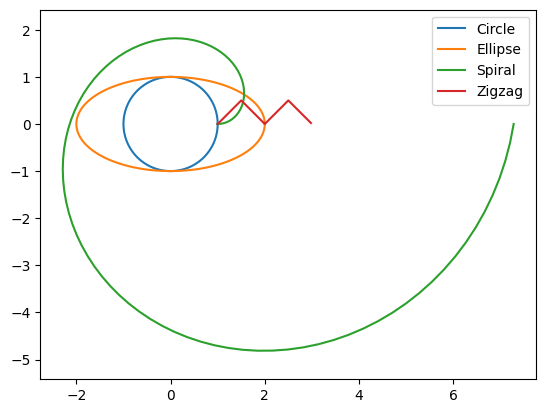

DSA Scores: [0.71487141 0.71617132 0.13496664 0.        ]
Procrustes Scores: [np.float32(0.104125604), np.float32(0.07930048), np.float32(0.04481018), np.float32(2.3140974e-09)]


/tmp/ipython-input-6-1836480784.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = A @ R - B


In [10]:
import torch
import matplotlib.pyplot as plt
import DSA

# Linear interpolation to 100 points along zigzag
def interp_line(points, n=100):
    segments = points.shape[0] - 1
    n = int(n)
    seg_length = n // segments
    interp_points = []
    for i in range(segments):
        start_p = points[i]
        end_p = points[i + 1]
        # Add 1 to seg_length to include endpoint, then exclude last point except for last segment
        segment_points = torch.stack([
            start_p * (1 - alpha) + end_p * alpha
            for alpha in torch.linspace(0, 1, seg_length + 1)
        ])
        if i < segments - 1:
            segment_points = segment_points[:-1]  # exclude last point to avoid duplicates
        interp_points.append(segment_points)
    return torch.cat(interp_points, dim=0)

# Generate array of time values
t = torch.linspace(0, 2 * torch.pi, 100)
start = torch.tensor([1.0, 0.0])

# Circular trajectory
circle = torch.stack([torch.cos(t), torch.sin(t)], dim=1)
# Ellipse
ellipse = torch.stack([2 * torch.cos(t), torch.sin(t)], dim=1)
# Spiral
spiral = torch.stack([t * torch.cos(t), t * torch.sin(t)], dim=1)
spiral = spiral - spiral[0] + start

# Define zigzag key points starting at (1,0)
zigzag_pts = torch.tensor([
    [1.0, 0.0],
    [1.5, 0.5],
    [2.0, 0.0],
    [2.5, 0.5],
    [3.0, 0.0]
])

# Zigzag Trajectory
zigzag = interp_line(zigzag_pts, 100)[:100]

# Plot them all on same graph
plt.plot(circle[:, 0], circle[:, 1], label='Circle')
plt.plot(ellipse[:, 0], ellipse[:, 1], label='Ellipse')
plt.plot(spiral[:, 0], spiral[:, 1], label='Spiral')
plt.plot(zigzag[:, 0], zigzag[:, 1], label='Zigzag')
plt.axis('equal')
plt.legend()
plt.show()

# Get DSA Scores
baseline_traj = circle
comparison_traj = [zigzag, spiral, ellipse, circle]

rank = 3
window_size = 10
space_between_samples = 1

dsa_scores = DSA.dsa.DSA(baseline_traj, comparison_traj, rank=rank, n_delays=window_size, delay_interval=space_between_samples, score_method = "angular", device=device).fit_score()[0]
print(f"DSA Scores: {dsa_scores}")

# Get Procrustes Scores
procrustes_scores = [procrustes_distance(baseline_traj, traj) for traj in comparison_traj]
print(f"Procrustes Scores: {procrustes_scores}")



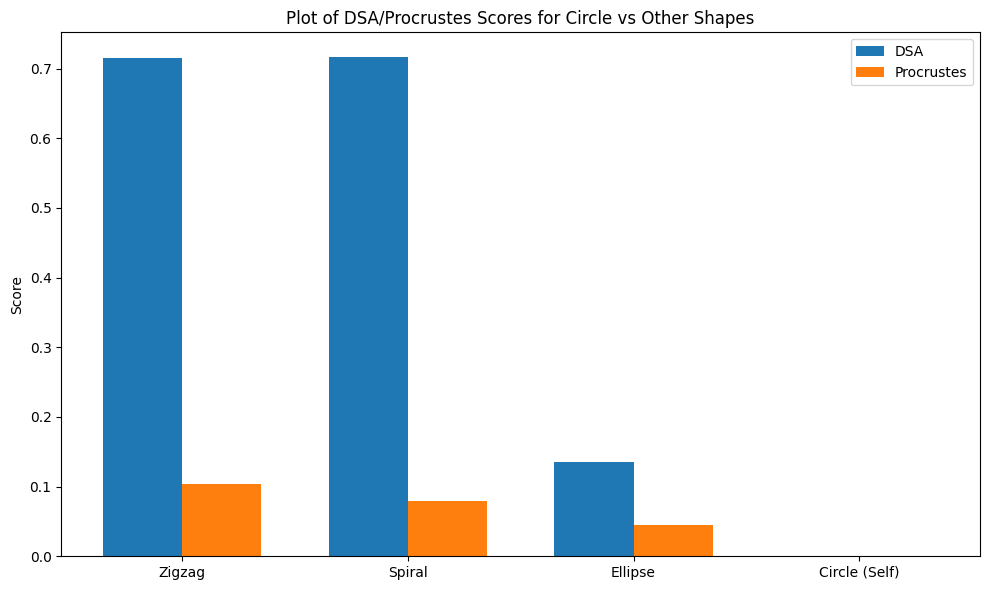

In [11]:
labels = ['Zigzag', 'Spiral', 'Ellipse', 'Circle (Self)']
title = "Plot of DSA/Procrustes Scores for Circle vs Other Shapes"
plot_dsa_procrustes(dsa_scores, procrustes_scores, labels, title=title)

## Plots/Results

### Plots for raw trajectories

100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


PCA explained 96.28% of variance


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


PCA explained 92.65% of variance


100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


PCA explained 96.28% of variance


100%|██████████| 15/15 [00:05<00:00,  2.82it/s]


PCA explained 94.33% of variance


100%|██████████| 15/15 [00:05<00:00,  2.82it/s]


PCA explained 96.28% of variance


100%|██████████| 15/15 [00:05<00:00,  2.82it/s]


PCA explained 93.27% of variance


100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


PCA explained 96.28% of variance


100%|██████████| 15/15 [00:05<00:00,  2.85it/s]


PCA explained 69.70% of variance


100%|██████████| 15/15 [00:05<00:00,  2.82it/s]


PCA explained 96.28% of variance


100%|██████████| 15/15 [00:05<00:00,  2.80it/s]


PCA explained 62.69% of variance


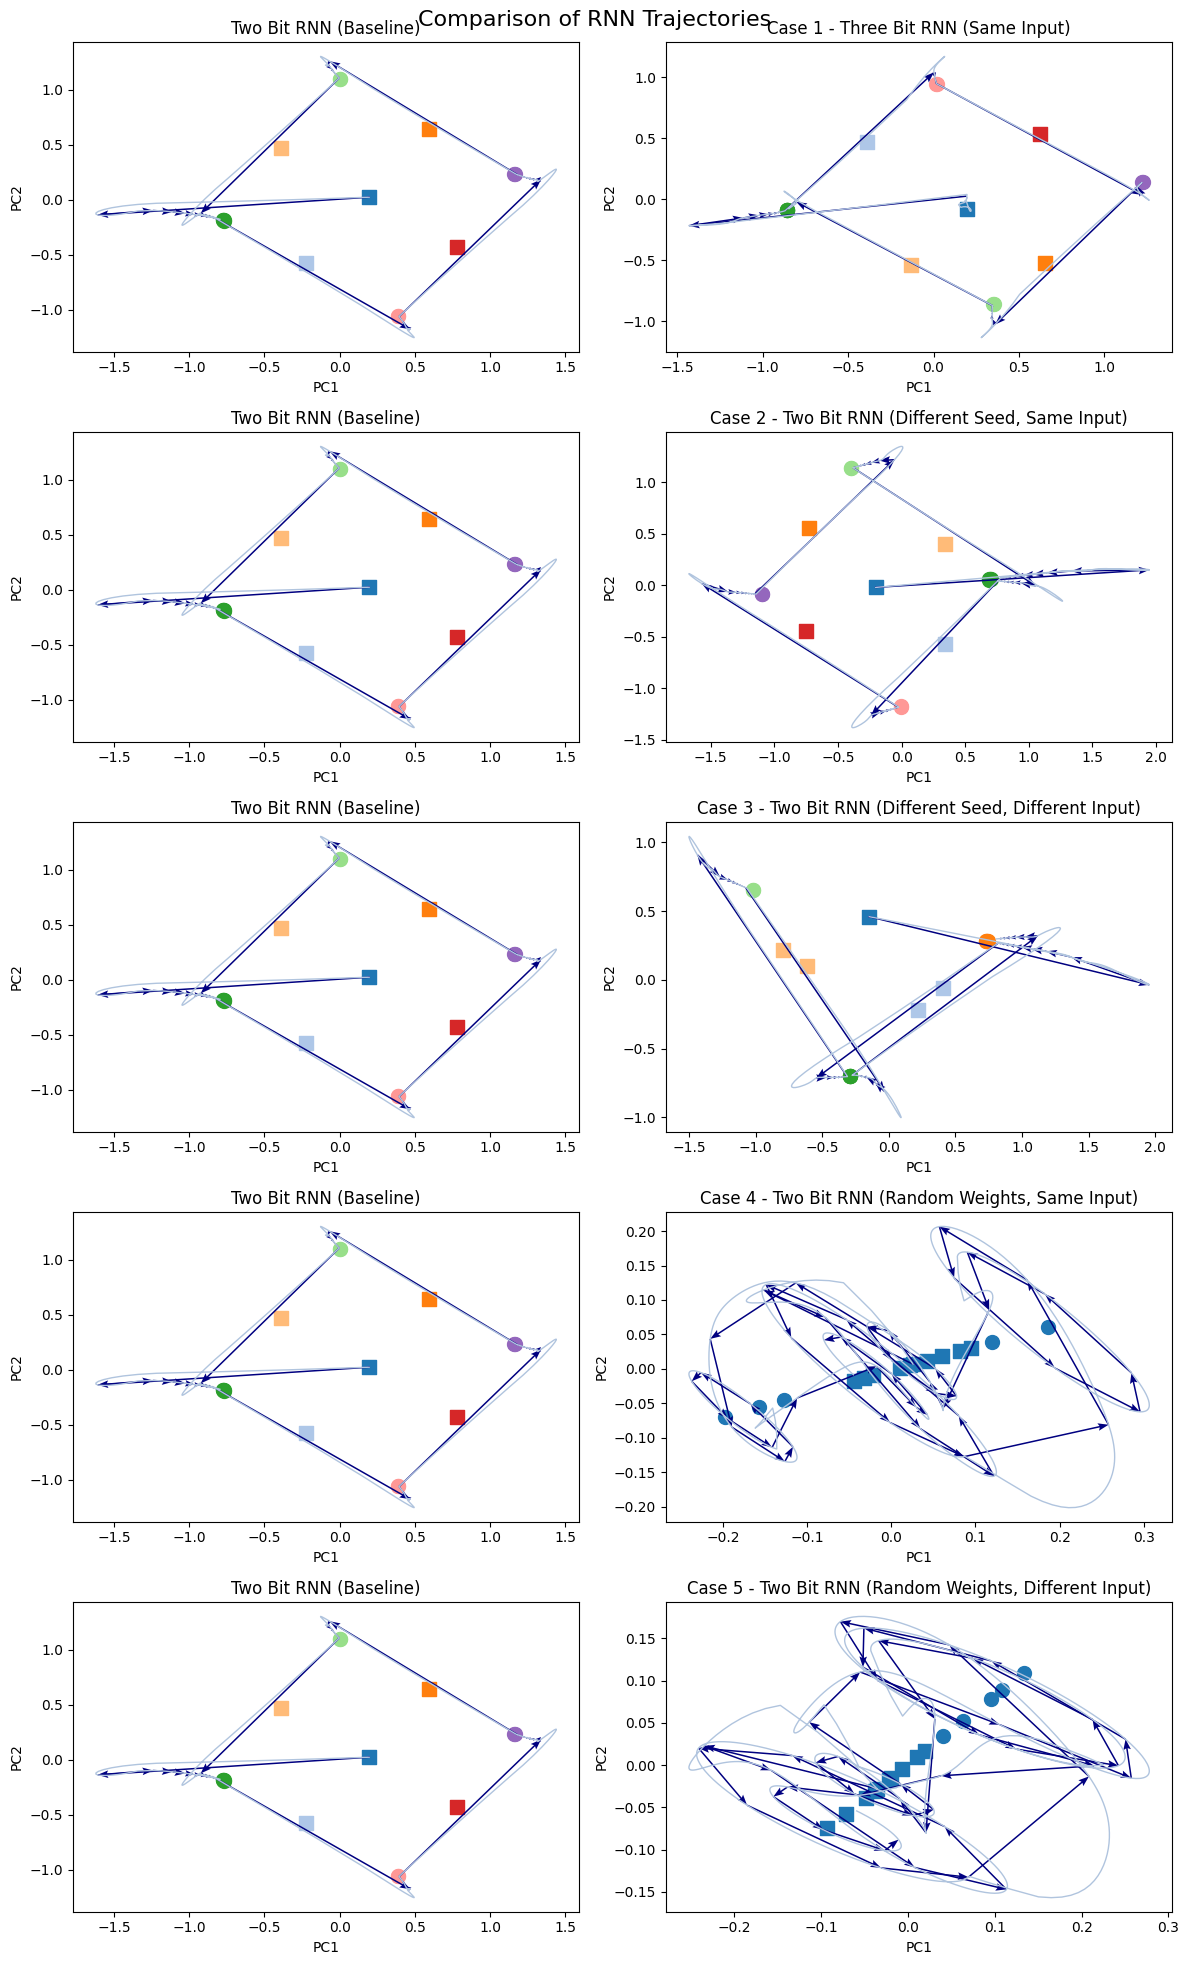

In [12]:
full_square = [
        [+1, +1],  # initial state
        [-1, +1],
        [-1, -1],
        [+1, -1],
        [+1, +1]   # close the loop
    ]
half_square = [
        [+1, +1],  # initial state
        [-1, +1],
        [-1, -1],
        [-1, +1],
        [+1, +1]   # close the loop
    ]

models_col_1 = [threebitrnn, twobitrnnseed444, twobitrnnseed444, twobitallrandom, twobitallrandom]
col_1_titles = ["Case 1 - Three Bit RNN (Same Input)",
                "Case 2 - Two Bit RNN (Different Seed, Same Input)",
                "Case 3 - Two Bit RNN (Different Seed, Different Input)",
                "Case 4 - Two Bit RNN (Random Weights, Same Input)",
                "Case 5 - Two Bit RNN (Random Weights, Different Input)",
                ]
input_transitions_list = [full_square, full_square, half_square, full_square, half_square]

overall_title = "Comparison of RNN Trajectories"

plot_multiple_trajectories(twobitrnn, models_col_1, col_1_titles, input_transitions_list, overall_title)

### Plots for smoothing pca reduced trajectories

100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


PCA explained 87.12% of variance


100%|██████████| 13/13 [00:03<00:00,  3.90it/s]


PCA explained 86.56% of variance


100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


PCA explained 88.20% of variance


100%|██████████| 13/13 [00:03<00:00,  3.84it/s]


PCA explained 87.45% of variance


100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


PCA explained 89.04% of variance


100%|██████████| 13/13 [00:03<00:00,  3.70it/s]


PCA explained 85.10% of variance


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


PCA explained 90.27% of variance


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


PCA explained 59.35% of variance


100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


PCA explained 89.71% of variance


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


PCA explained 57.23% of variance


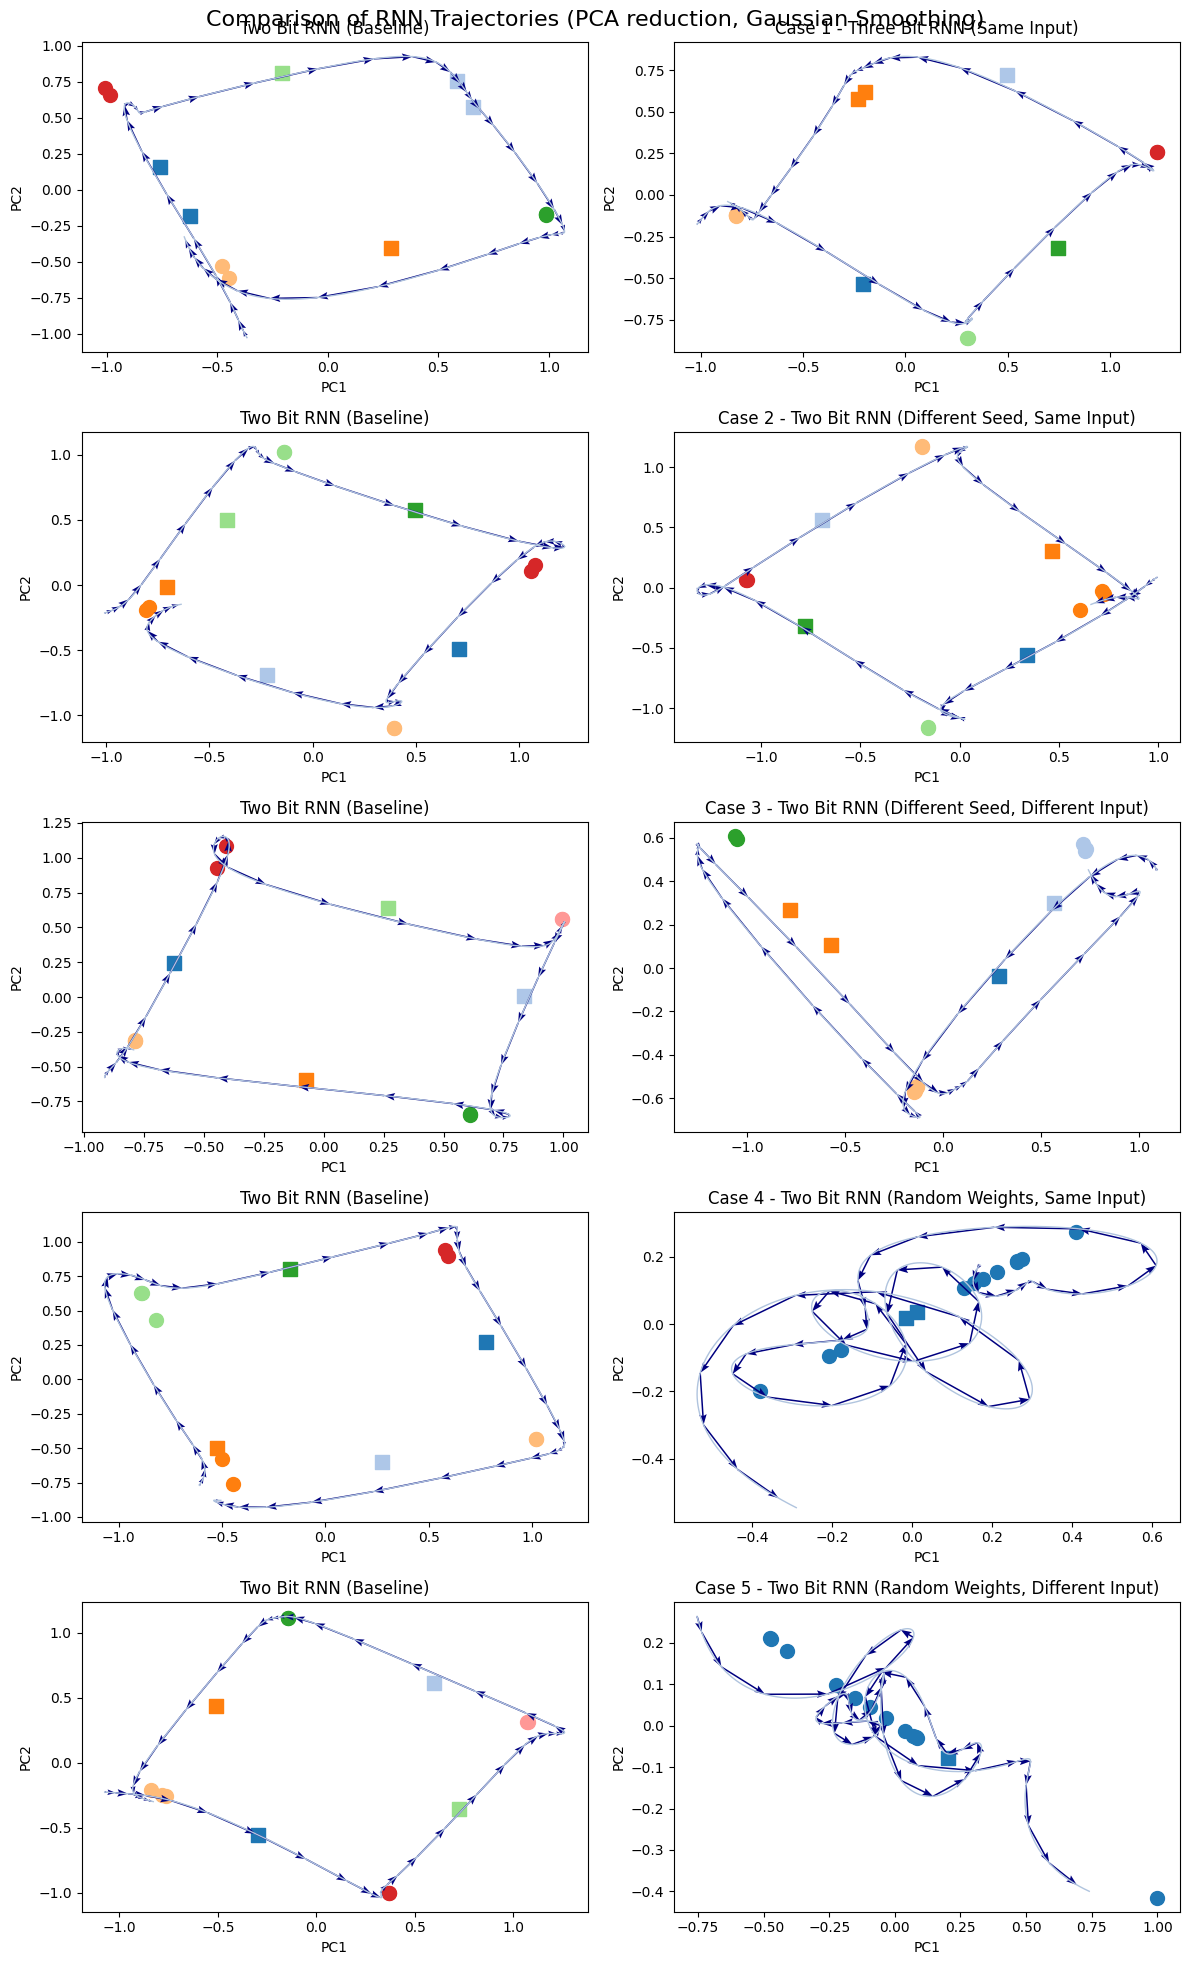

In [102]:
full_square = [
        [+1, +1],  # initial state
        [-1, +1],
        [-1, -1],
        [+1, -1],
        [+1, +1]   # close the loop
    ]
half_square = [
        [+1, +1],  # initial state
        [-1, +1],
        [-1, -1],
        [-1, +1],
        [+1, +1]   # close the loop
    ]

models_col_1 = [threebitrnn, twobitrnnseed444, twobitrnnseed444, twobitallrandom, twobitallrandom]
col_1_titles = ["Case 1 - Three Bit RNN (Same Input)",
                "Case 2 - Two Bit RNN (Different Seed, Same Input)",
                "Case 3 - Two Bit RNN (Different Seed, Different Input)",
                "Case 4 - Two Bit RNN (Random Weights, Same Input)",
                "Case 5 - Two Bit RNN (Random Weights, Different Input)",
                ]
input_transitions_list = [full_square, full_square, half_square, full_square, half_square]

overall_title = "Comparison of RNN Trajectories (PCA reduction, Gaussian Smoothing)"

plot_multiple_trajectories(twobitrnn, models_col_1, col_1_titles, input_transitions_list, overall_title, burn_in=250, smooth=True, sigma=50.0, add_noise=True)

### DSA scores for raw trajectories

In [13]:
import DSA

full_square = [
        [+1, +1],  # initial state
        [-1, +1],
        [-1, -1],
        [+1, -1],
        [+1, +1]   # close the loop
    ]
half_square = [
        [+1, +1],  # initial state
        [-1, +1],
        [-1, -1],
        [-1, +1],
        [+1, +1]   # close the loop
    ]

dsa_models = [threebitrnn, twobitrnnseed444, twobitrnnseed444, twobitallrandom, twobitallrandom, twobitrnn]
dsa_inputs = [full_square, full_square, half_square, full_square, half_square, full_square]

baseline_hs_no_noise = get_hs_for_dsa(twobitrnn, full_square, n_bits=twobitrnn.n_bits)
noise_std = 0.01
baseline_hs_noise_1 = get_hs_for_dsa(twobitrnn, full_square, n_bits=twobitrnn.n_bits, add_noise=True)

hs_no_noise = [random_tensor]
hs_noise_1 = [random_tensor]
hs_noise_2 = [random_tensor]
for i in range(len(dsa_models)):
    hs_no_noise.append(get_hs_for_dsa(dsa_models[i], dsa_inputs[i], n_bits=dsa_models[i].n_bits))
    noise_std = 0.01
    hs_noise_1.append(get_hs_for_dsa(dsa_models[i], dsa_inputs[i], n_bits=dsa_models[i].n_bits, add_noise=True))
    noise_std = 0.1
    hs_noise_2.append(get_hs_for_dsa(dsa_models[i], dsa_inputs[i], n_bits=dsa_models[i].n_bits, add_noise=True))



noise_std = 0.015

p=280
r=7
delay_interval=5

#dsa_model_no_noise = DSA.dsa.DSA(baseline_hs_no_noise, hs_no_noise, rank=r, n_delays=p, score_method = "angular", device=device)
dsa_scores_no_noise = DSA.dsa.DSA(baseline_hs_no_noise, hs_no_noise, rank=r, n_delays=p, delay_interval=delay_interval, score_method = "angular", device=device).fit_score()
print(dsa_scores_no_noise)

#dsa_model_noise_1 = DSA.dsa.DSA(baseline_hs_noise_1, hs_noise_1, rank=r, n_delays=p, score_method = "angular", device=device)
dsa_scores_noise_1 = DSA.dsa.DSA(baseline_hs_noise_1, hs_noise_1, rank=r, n_delays=p, delay_interval=delay_interval, score_method = "angular", device=device).fit_score()
print(dsa_scores_noise_1)

#dsa_model_noise_2 = DSA.dsa.DSA(baseline_hs_noise_1, hs_noise_2, rank=r, n_delays=p, score_method = "angular", device=device)
dsa_scores_noise_2 = DSA.dsa.DSA(baseline_hs_noise_1, hs_noise_2, rank=r, n_delays=p, delay_interval=delay_interval, score_method = "angular", device=device).fit_score()
print(dsa_scores_noise_2)


[[2.43325210e+00 1.19603996e-03 2.97009991e-03 3.20187560e-03
  5.21342317e-03 4.44845762e-03 0.00000000e+00]]
[[2.43392873 0.00338291 0.00436732 0.00284715 0.00633827 0.00551348
  0.00343536]]
[[2.43392873 0.00947445 0.00788089 0.00908259 0.00478416 0.00687074
  0.00753285]]


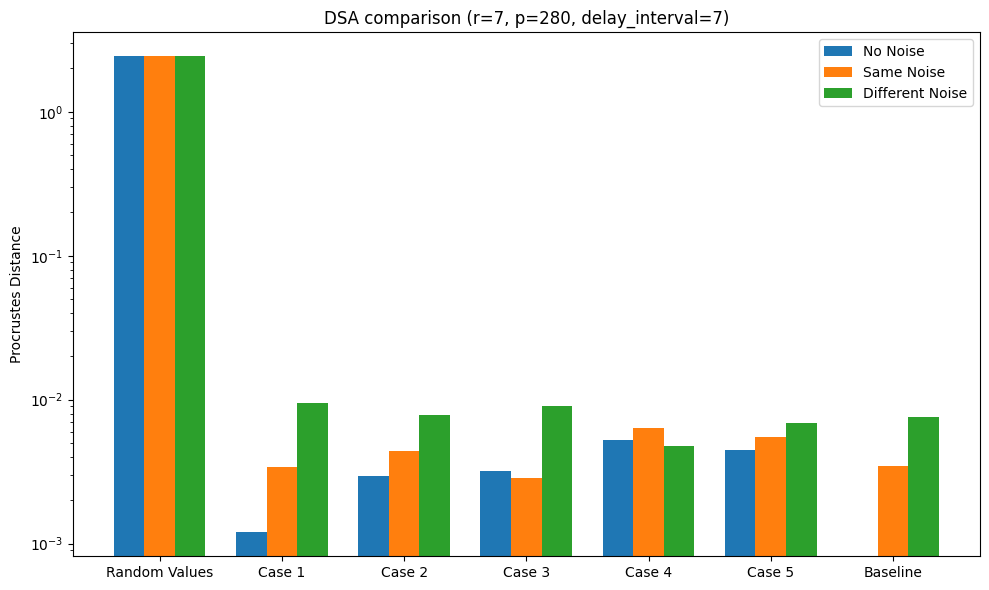

In [14]:
bar_titles = ["Random Values", "Case 1", "Case 2", "Case 3", "Case 4", "Case 5", "Baseline"]
plot_title = "DSA comparison (r=7, p=280, delay_interval=7)"
plot_grouped_bars(dsa_scores_no_noise[0], dsa_scores_noise_1[0], dsa_scores_noise_2[0], bar_titles, plot_title, log_scale=True)

In [61]:
dsa_scores_noise_2[0].shape

(7,)

### DSA scores for smoothed, PCA reduced trajectories

[[0.         0.         0.00336525 0.00338291 0.00436732 0.        ]]
[[0.00048828 0.         0.00284715 0.00274047 0.00119604 0.00059802]]
[[0.00429854 0.00327549 0.00472146 0.00982044 0.00934778 0.00210018]]


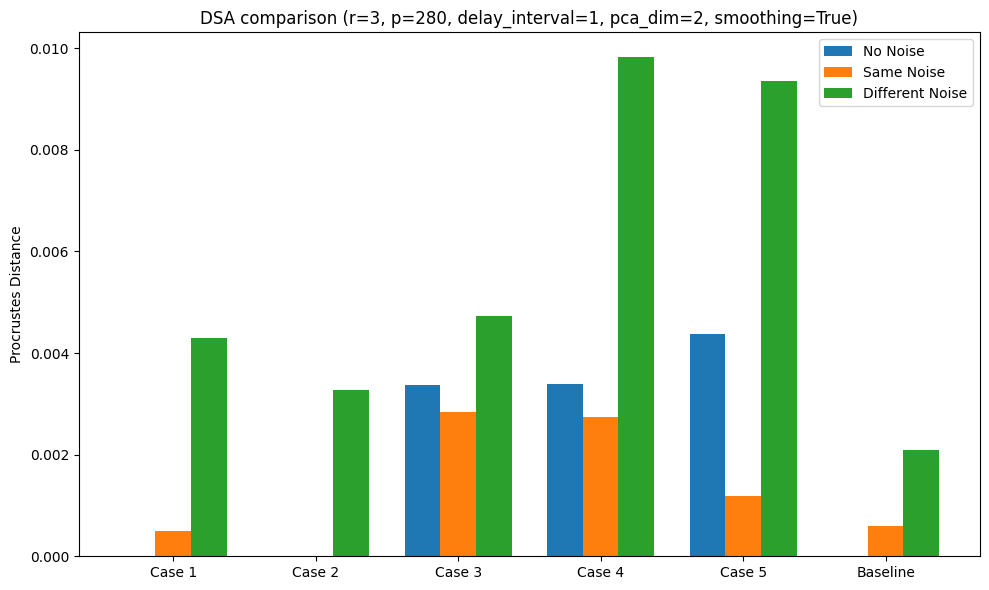

In [15]:
import DSA

full_square = [
        [+1, +1],  # initial state
        [-1, +1],
        [-1, -1],
        [+1, -1],
        [+1, +1]   # close the loop
    ]
half_square = [
        [+1, +1],  # initial state
        [-1, +1],
        [-1, -1],
        [-1, +1],
        [+1, +1]   # close the loop
    ]

dsa_models = [threebitrnn, twobitrnnseed444, twobitrnnseed444, twobitallrandom, twobitallrandom, twobitrnn]
dsa_inputs = [full_square, full_square, half_square, full_square, half_square, full_square]

burn_in=250
pca_dim=2
smooth=True
sigma=50.0

baseline_hs_no_noise = get_hs_for_dsa(twobitrnn, full_square, n_bits=twobitrnn.n_bits, burn_in=burn_in, pca_dim=2, smooth=smooth, sigma=sigma)
noise_std = 0.01
baseline_hs_noise_1 = get_hs_for_dsa(twobitrnn, full_square, n_bits=twobitrnn.n_bits, add_noise=True, burn_in=burn_in, pca_dim=2, smooth=smooth, sigma=sigma)

#hs_no_noise = [random_tensor[:,:2]]
#hs_noise_1 = [random_tensor[:,:2]]
#hs_noise_2 = [random_tensor[:,:2]]

hs_no_noise = []
hs_noise_1 = []
hs_noise_2 = []


for i in range(len(dsa_models)):
    hs_no_noise.append(get_hs_for_dsa(dsa_models[i], dsa_inputs[i], n_bits=dsa_models[i].n_bits, burn_in=burn_in, pca_dim=2, smooth=smooth, sigma=sigma))
    noise_std = 0.01
    hs_noise_1.append(get_hs_for_dsa(dsa_models[i], dsa_inputs[i], n_bits=dsa_models[i].n_bits, add_noise=True, pca_dim=2, burn_in=burn_in, smooth=smooth, sigma=sigma))
    noise_std = 0.1
    hs_noise_2.append(get_hs_for_dsa(dsa_models[i], dsa_inputs[i], n_bits=dsa_models[i].n_bits, add_noise=True, pca_dim=2, burn_in=burn_in, smooth=smooth, sigma=sigma))


noise_std = 0.015

p=280
r=3
delay_interval=1

#dsa_model_no_noise = DSA.dsa.DSA(baseline_hs_no_noise, hs_no_noise, rank=r, n_delays=p, score_method = "angular", device=device)
dsa_scores_no_noise = DSA.dsa.DSA(baseline_hs_no_noise, hs_no_noise, rank=r, n_delays=p, delay_interval=delay_interval, score_method = "angular", device=device).fit_score()
print(dsa_scores_no_noise)

#dsa_model_noise_1 = DSA.dsa.DSA(baseline_hs_noise_1, hs_noise_1, rank=r, n_delays=p, score_method = "angular", device=device)
dsa_scores_noise_1 = DSA.dsa.DSA(baseline_hs_noise_1, hs_noise_1, rank=r, n_delays=p, delay_interval=delay_interval, score_method = "angular", device=device).fit_score()
print(dsa_scores_noise_1)

#dsa_model_noise_2 = DSA.dsa.DSA(baseline_hs_noise_1, hs_noise_2, rank=r, n_delays=p, score_method = "angular", device=device)
dsa_scores_noise_2 = DSA.dsa.DSA(baseline_hs_noise_1, hs_noise_2, rank=r, n_delays=p, delay_interval=delay_interval, score_method = "angular", device=device).fit_score()
print(dsa_scores_noise_2)

bar_titles = ["Case 1", "Case 2", "Case 3", "Case 4", "Case 5", "Baseline"]
plot_title = f"DSA comparison (r={r}, p={p}, delay_interval={delay_interval}, pca_dim={pca_dim}, smoothing={smooth})"
plot_grouped_bars(dsa_scores_no_noise[0], dsa_scores_noise_1[0], dsa_scores_noise_2[0], bar_titles, plot_title)

In [52]:
baseline_hs_no_noise[0].shape

torch.Size([1600, 100])

### Multiple Trajectories

[[0.01341673 0.00314553 0.02300939 0.00314553]]
[[0.01343449 0.00288871 0.02348885 0.00265205]]
[[0.01147207 0.00545916 0.02749244 0.00751701]]


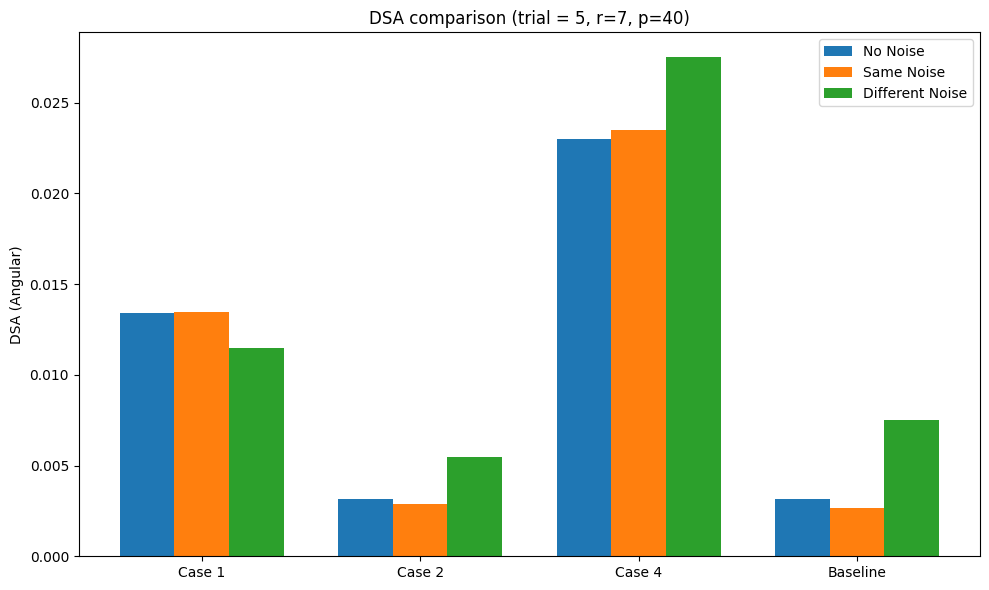

In [85]:
import DSA

dsa_models = [threebitrnn, twobitrnnseed444, twobitallrandom, twobitrnn]
dsa_inputs = [full_square, full_square, half_square, full_square, half_square, full_square]

#baseline_hs_no_noise = get_hs_for_dsa(twobitrnn, full_square, n_bits=twobitrnn.n_bits)
baseline_hs_no_noise = get_hidden_states(twobitrnn, eval_input_2bit, add_noise=False, squeeze=False)
noise_std = 0.01
baseline_hs_noise_1 = get_hidden_states(twobitrnn, eval_input_2bit, add_noise=True, squeeze=False)

hs_no_noise = []
hs_noise_1 = []
hs_noise_2 = []

for i in range(len(dsa_models)):
    n_bits = dsa_models[i].n_bits
    if n_bits == 3:
        input = eval_input_3bit_5000
    else:
        input = eval_input_2bit_5000

    hs_no_noise.append(get_hidden_states(dsa_models[i], input, squeeze=False))
    noise_std = 0.01
    hs_noise_1.append(get_hidden_states(dsa_models[i], input, add_noise=True, squeeze=False))
    noise_std = 0.1
    hs_noise_2.append(get_hidden_states(dsa_models[i], input, add_noise=True, squeeze=False))

noise_std = 0.015

p=40
r=7
delay_interval=1

#dsa_model_no_noise = DSA.dsa.DSA(baseline_hs_no_noise, hs_no_noise, rank=r, n_delays=p, score_method = "angular", device=device)
dsa_scores_no_noise = DSA.dsa.DSA(baseline_hs_no_noise, hs_no_noise, rank=r, n_delays=p, delay_interval=delay_interval, score_method = "angular", device=device).fit_score()
print(dsa_scores_no_noise)

#dsa_model_noise_1 = DSA.dsa.DSA(baseline_hs_noise_1, hs_noise_1, rank=r, n_delays=p, score_method = "angular", device=device)
dsa_scores_noise_1 = DSA.dsa.DSA(baseline_hs_noise_1, hs_noise_1, rank=r, n_delays=p, delay_interval=delay_interval, score_method = "angular", device=device).fit_score()
print(dsa_scores_noise_1)

#dsa_model_noise_2 = DSA.dsa.DSA(baseline_hs_noise_1, hs_noise_2, rank=r, n_delays=p, score_method = "angular", device=device)
dsa_scores_noise_2 = DSA.dsa.DSA(baseline_hs_noise_1, hs_noise_2, rank=r, n_delays=p, delay_interval=delay_interval, score_method = "angular", device=device).fit_score()
print(dsa_scores_noise_2)

bar_titles = ["Case 1", "Case 2", "Case 4", "Baseline"]
plot_title = f"DSA comparison (trial = 5, r={r}, p={p})"
plot_grouped_bars(dsa_scores_no_noise[0], dsa_scores_noise_1[0], dsa_scores_noise_2[0], bar_titles, plot_title)

In [78]:
baseline_hs_no_noise.shape
[x.shape for x in hs_no_noise]

[torch.Size([5, 1000, 100]),
 torch.Size([5, 1000, 100]),
 torch.Size([5, 1000, 100]),
 torch.Size([5, 1000, 100])]

### Hyperparameter Search

#### Rank

In [44]:
#DSA.dsa.DSA(baseline_hs_no_noise, hs_no_noise[4], rank=10, n_delays=140, device=device).fit_score()
#rank_test_dsa = DSA.dsa.DSA([baseline_hs_no_noise, baseline_hs_no_noise, baseline_hs_no_noise, baseline_hs_no_noise, baseline_hs_no_noise], [hs_no_noise[4], hs_no_noise[4], hs_no_noise[4], hs_no_noise[4], hs_no_noise[4]], rank=[[2, 5, 10, 20, 50], [2, 5, 10, 20, 50]], n_delays=140, device=device).fit_score()
rank_test_dsa = []
ranks = [2, 5, 10, 20, 50]
for r in ranks:
    rank_test_dsa.append(DSA.dsa.DSA(baseline_hs_no_noise, hs_no_noise[1], rank=r, n_delays=140, device=device).fit_score())
print(rank_test_dsa)

[np.float64(0.0), np.float64(0.0005980199784971774), np.float64(0.001691456069238484), np.float64(0.008235925808548927), np.float64(0.016815798357129097)]


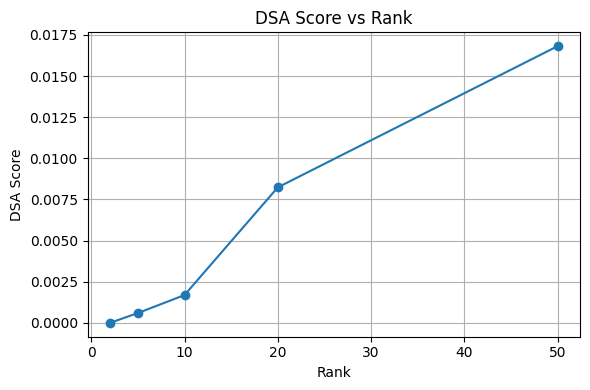

In [45]:
import matplotlib.pyplot as plt

ranks = [2, 5, 10, 20, 50]
scores = rank_test_dsa     # your computed DSA scores

plt.figure(figsize=(6, 4))
plt.plot(ranks, scores, marker='o')
plt.xlabel("Rank")
plt.ylabel("DSA Score")
plt.title("DSA Score vs Rank")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
9, 6, 11, 11,

#### Manual DSA Sandbox

In [53]:
import numpy as np
import torch

import DSA  # Top-level DSA package

# Sample data
#X = [np.random.randn(100, 5) for _ in range(3)]
#Y = [np.random.randn(100, 5) for _ in range(3)]

# --- Initialise DSA object ---
#dsa = DSA.dsa.DSA(X, Y, n_delays=10, delay_interval=1, rank=5)
my_dsa = DSA.dsa.DSA(baseline_hs_no_noise, hs_no_noise[2], rank=10, n_delays=280, device=device)
#my_dsa = DSA.dsa.DSA(baseline_hs_no_noise, hs_no_noise[4], rank=10, n_delays=140, device=device)

# --- Access a single DMD ---
my_dmd = my_dsa.dmds[0][0]

# --- Step-by-step DMD fit ---

# 1. Compute Hankel matrix
my_dmd.compute_hankel()
print("Hankel matrix shape:", my_dmd.H.shape)

# 2. Compute SVD
my_dmd.compute_svd()
print("SVD - U shape:", my_dmd.U.shape)
print("SVD - S shape:", my_dmd.S.shape)
print("SVD - V shape:", my_dmd.V.shape)

# 3. Explained variance: how many singular values explain >95%?
S = my_dmd.S
explained = (S**2) / torch.sum(S**2)
cumulative = torch.cumsum(explained, dim=0)
num_components_95 = torch.sum(cumulative < 0.95).item() + 1
print(f"Number of components explaining >95% variance: {num_components_95}")

# 4. Inspect V matrix and regression inputs
print("V matrix (right singular vectors):\n", my_dmd.V)
print("Vt_minus shape:", my_dmd.Vt_minus.shape)
print("Vt_plus shape:", my_dmd.Vt_plus.shape)

# 5. Apply rank and compute DMD
my_dmd.recalc_rank(rank=my_dsa.rank[0][0], rank_thresh=None, rank_explained_variance=None)
my_dmd.compute_havok_dmd()

# --- Continue with full fit/score if needed ---
sim_matrix = my_dsa.fit_score()
print("Similarity matrix:\n", sim_matrix)

Hankel matrix shape: torch.Size([1321, 28000])
SVD - U shape: torch.Size([28000, 1321])
SVD - S shape: torch.Size([1321])
SVD - V shape: torch.Size([1321, 1321])
Number of components explaining >95% variance: 14
V matrix (right singular vectors):
 tensor([[-2.4326e-02, -1.4370e-03, -5.0285e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.4493e-02, -1.5216e-03, -5.0678e-02,  ...,  3.4432e-06,
         -5.6621e-07, -8.8840e-07],
        [-2.4659e-02, -1.6072e-03, -5.1060e-02,  ..., -7.1466e-07,
          1.0571e-06,  1.3318e-06],
        ...,
        [-3.5704e-02, -1.2195e-02, -1.8845e-02,  ...,  3.3382e-03,
         -3.1646e-03,  2.3008e-03],
        [-3.5640e-02, -1.2404e-02, -1.8807e-02,  ..., -3.1782e-03,
          1.2905e-03, -1.3694e-03],
        [-3.5575e-02, -1.2612e-02, -1.8764e-02,  ...,  7.9428e-04,
          1.9467e-04,  2.4985e-04]])
Vt_minus shape: torch.Size([1320, 1321])
Vt_plus shape: torch.Size([1320, 1321])
Similarity matrix:
 0.00644088303670287

#### Grid search implementation

In [32]:
import torch
import gc
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import DSA  # use DSA.dsa.DSA explicitly

def run_dsa_gridsearch(X, Y, n_delay_list, device='cpu'):
    delay_interval_list = [1, 5, 20, 70, 140]
    results = []
    T = X.shape[0] if isinstance(X, torch.Tensor) else X[0].shape[0]

    for n_delays in tqdm(n_delay_list):
        for delay_interval in delay_interval_list:
            #if (n_delays - 1) * delay_interval >= T:
            #    results.append({
            #        "n_delays": n_delays,
            #        "delay_interval": delay_interval,
            #        "optimal_rank": None,
            #        "spectrum_decay_metric": np.nan
            #    })
            #    continue

            try:
                my_dsa = DSA.dsa.DSA(
                    X, Y,
                    rank=10,
                    n_delays=n_delays,
                    delay_interval=delay_interval,
                    device=device,
                    verbose=False
                )

                decay_values = []
                for i, dmd_set in enumerate(my_dsa.dmds):
                    for j, dmd in enumerate(dmd_set):
                        dmd.fit()
                        if dmd.S is None:
                            raise ValueError("SVD not computed.")
                        s = dmd.S.cpu().numpy()
                        explained = np.cumsum(s**2) / np.sum(s**2)
                        num_components_95 = np.searchsorted(explained, 0.95) + 1
                        decay_values.append(num_components_95)
                        my_dsa.dmds[i][j] = None  # free memory ASAP

                del my_dsa.dmds
                gc.collect()

                #spectrum_decay_metric = np.mean(decay_values)
                max_rank = np.max(decay_values)
                spectrum_decay_metric = max_rank

            except Exception as e:
                print(f"Skipping n_delays={n_delays}, delay_interval={delay_interval} due to error: {e}")
                spectrum_decay_metric = np.nan

            del my_dsa
            gc.collect()

            results.append({
                "n_delays": n_delays,
                "delay_interval": delay_interval,
                "optimal_rank": max_rank,
                "spectrum_decay_metric": spectrum_decay_metric
            })

    return pd.DataFrame(results)


def plot_max_rank(df):
    plt.figure(figsize=(8, 6))
    for n_delay in sorted(df['n_delays'].dropna().unique()):
        df_sub = df[(df['n_delays'] == n_delay) & (df['spectrum_decay_metric'].notna())]
        if not df_sub.empty:
            plt.plot(df_sub['delay_interval'], df_sub['spectrum_decay_metric'], marker='o', label=f'n_delays = {n_delay}')
    plt.xlabel("Delay Interval")
    plt.ylabel("Max rank for 95% var")
    plt.title("Max Rank vs Delay Interval for Different n_delays")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [66]:
df_results = run_dsa_gridsearch(baseline_hs_no_noise, hs_no_noise[1:3], n_delay_list=[20, 140, 280])
#plot_decay(df_decay)

 33%|███▎      | 1/3 [00:03<00:06,  3.21s/it]

Skipping n_delays=20, delay_interval=140 due to error: The number of delays is too large for the number of time points in the data!
Skipping n_delays=140, delay_interval=20 due to error: The number of delays is too large for the number of time points in the data!
Skipping n_delays=140, delay_interval=70 due to error: The number of delays is too large for the number of time points in the data!
Skipping n_delays=140, delay_interval=140 due to error: The number of delays is too large for the number of time points in the data!


 67%|██████▋   | 2/3 [00:05<00:02,  2.83s/it]

Skipping n_delays=280, delay_interval=5 due to error: The number of delays is too large for the number of time points in the data!
Skipping n_delays=280, delay_interval=20 due to error: The number of delays is too large for the number of time points in the data!
Skipping n_delays=280, delay_interval=70 due to error: The number of delays is too large for the number of time points in the data!


100%|██████████| 3/3 [00:08<00:00,  2.67s/it]

Skipping n_delays=280, delay_interval=140 due to error: The number of delays is too large for the number of time points in the data!


In [67]:
df_results

,n_delays,delay_interval,optimal_rank,spectrum_decay_metric
0,20,1,2,2.0
1,20,5,2,2.0
2,20,20,3,3.0
3,20,70,1,1.0
4,20,140,1,NaN
5,140,1,2,2.0
6,140,5,3,3.0
7,140,20,3,NaN
8,140,70,3,NaN
9,140,140,3,NaN


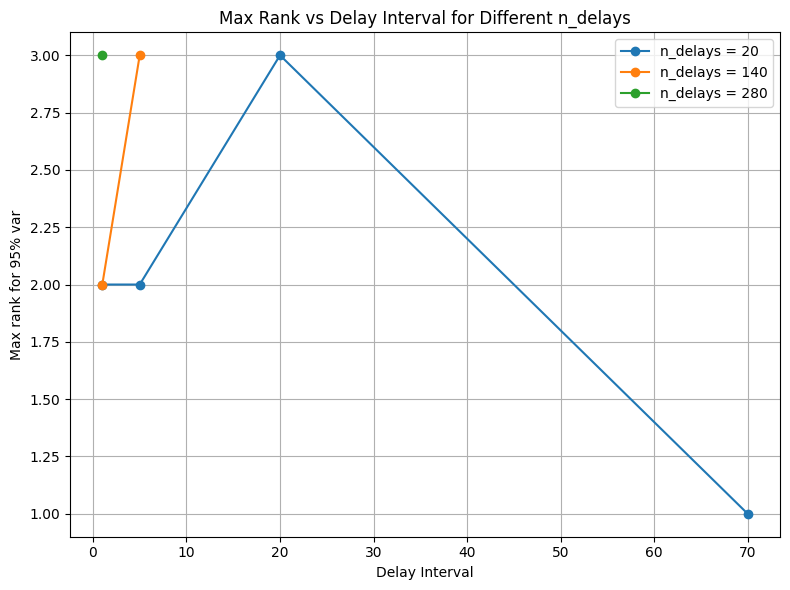

In [68]:
plot_max_rank(df_results)

### Procrustes

[np.float32(399.5719), np.float32(31.994661), np.float32(4.7036138), np.float32(40.610653), np.float32(40.186733), np.float32(42.926094), np.float32(0.01748949)]
[np.float32(398.315), np.float32(34.836338), np.float32(14.692732), np.float32(39.458176), np.float32(43.76839), np.float32(45.84897), np.float32(12.371917)]
[np.float32(398.315), np.float32(96.224075), np.float32(98.98747), np.float32(98.2663), np.float32(114.510796), np.float32(117.247856), np.float32(97.86104)]


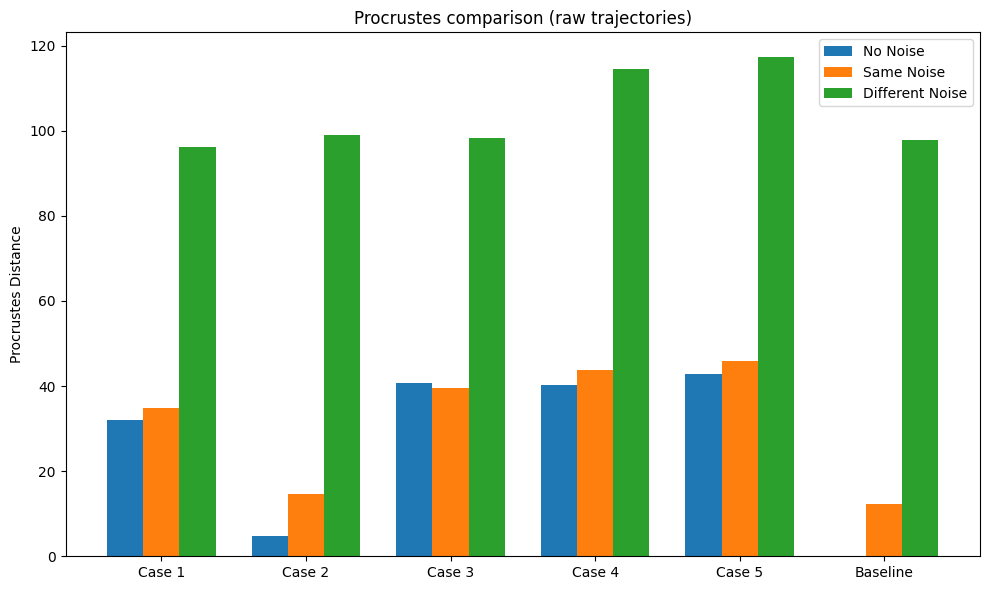

In [97]:
procrustes_scores_no_noise = [procrustes_distance(baseline_hs_no_noise.cpu().numpy(), hs_no_noise[i].cpu().numpy()) for i in range(1+len(dsa_models))]
print(procrustes_scores_no_noise)
procrustes_scores_noise_1 = [procrustes_distance(baseline_hs_noise_1.cpu().numpy(), hs_noise_1[i].cpu().numpy()) for i in range(1+len(dsa_models))]
print(procrustes_scores_noise_1)
procrustes_scores_noise_2 = [procrustes_distance(baseline_hs_noise_1.cpu().numpy(), hs_noise_2[i].cpu().numpy()) for i in range(1+len(dsa_models))]
print(procrustes_scores_noise_2)

bar_titles = ["Case 1", "Case 2", "Case 3", "Case 4", "Case 5", "Baseline"]
plot_title = "Procrustes comparison (raw trajectories)"
plot_grouped_bars(procrustes_scores_no_noise[1:], procrustes_scores_noise_1[1:], procrustes_scores_noise_2[1:], bar_titles, plot_title, log_scale=False)

[np.float32(5.0378203), np.float32(1.9137414), np.float32(30.859037), np.float32(33.884895), np.float32(36.205463), np.float32(9.8556175e-06)]
[np.float32(6.9787335), np.float32(4.961233), np.float32(29.158346), np.float32(31.512154), np.float32(32.790535), np.float32(5.4238944)]
[np.float32(30.495518), np.float32(35.562668), np.float32(40.89293), np.float32(39.346992), np.float32(46.874043), np.float32(29.01931)]


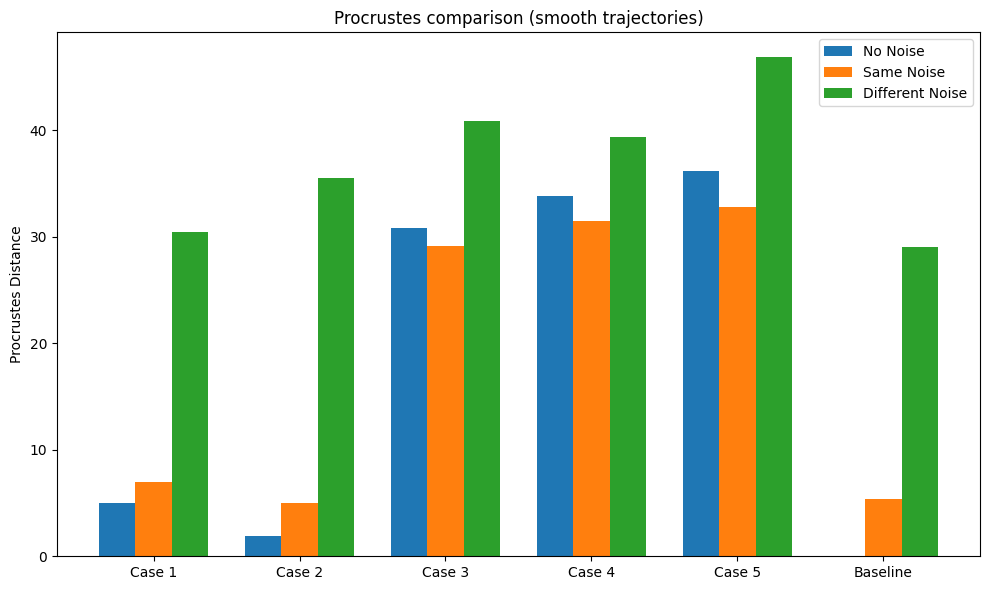

In [100]:
procrustes_scores_no_noise = [procrustes_distance(baseline_hs_no_noise.cpu().numpy(), hs_no_noise[i].cpu().numpy()) for i in range(len(dsa_models))]
print(procrustes_scores_no_noise)
procrustes_scores_noise_1 = [procrustes_distance(baseline_hs_noise_1.cpu().numpy(), hs_noise_1[i].cpu().numpy()) for i in range(len(dsa_models))]
print(procrustes_scores_noise_1)
procrustes_scores_noise_2 = [procrustes_distance(baseline_hs_noise_1.cpu().numpy(), hs_noise_2[i].cpu().numpy()) for i in range(len(dsa_models))]
print(procrustes_scores_noise_2)

bar_titles = ["Case 1", "Case 2", "Case 3", "Case 4", "Case 5", "Baseline"]
plot_title = "Procrustes comparison (smooth trajectories)"
plot_grouped_bars(procrustes_scores_no_noise, procrustes_scores_noise_1, procrustes_scores_noise_2, bar_titles, plot_title, log_scale=False)

[np.float32(3.6420445), np.float32(1.2883701), np.float32(12.25087), np.float32(22.344257), np.float32(23.414904), np.float32(2.663513e-06)]
[np.float32(4.3575525), np.float32(2.5913765), np.float32(11.985771), np.float32(18.518032), np.float32(23.628717), np.float32(2.2283363)]
[np.float32(16.532463), np.float32(17.45211), np.float32(16.71072), np.float32(25.196651), np.float32(27.482588), np.float32(17.964197)]


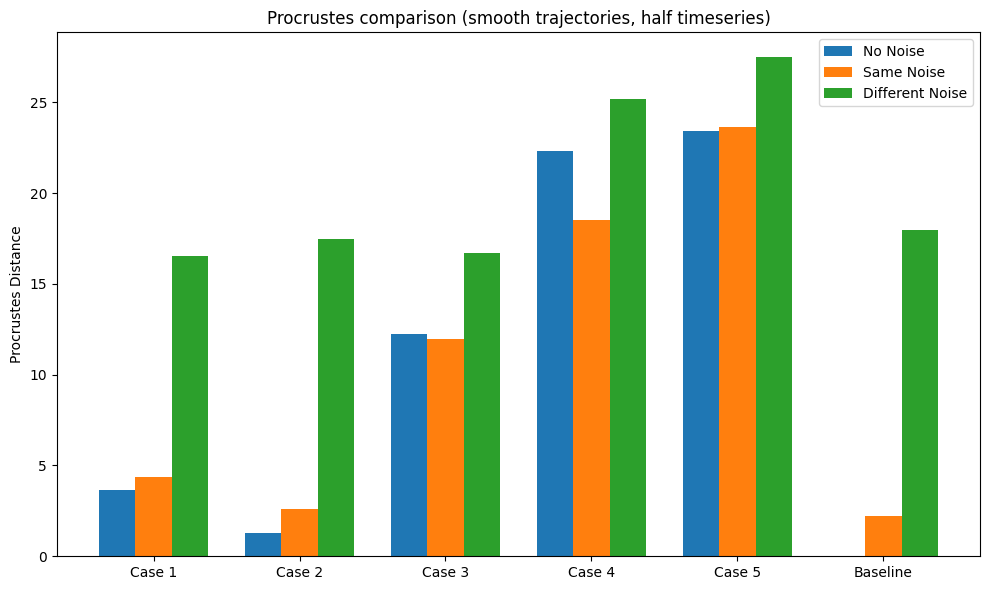

In [106]:
procrustes_scores_no_noise = [procrustes_distance(baseline_hs_no_noise[:600].cpu().numpy(), hs_no_noise[i][:600].cpu().numpy()) for i in range(len(dsa_models))]
print(procrustes_scores_no_noise)
procrustes_scores_noise_1 = [procrustes_distance(baseline_hs_noise_1[:600].cpu().numpy(), hs_noise_1[i][:600].cpu().numpy()) for i in range(len(dsa_models))]
print(procrustes_scores_noise_1)
procrustes_scores_noise_2 = [procrustes_distance(baseline_hs_noise_1[:600].cpu().numpy(), hs_noise_2[i][:600].cpu().numpy()) for i in range(len(dsa_models))]
print(procrustes_scores_noise_2)

bar_titles = ["Case 1", "Case 2", "Case 3", "Case 4", "Case 5", "Baseline"]
plot_title = "Procrustes comparison (smooth trajectories, half timeseries)"
plot_grouped_bars(procrustes_scores_no_noise, procrustes_scores_noise_1, procrustes_scores_noise_2, bar_titles, plot_title, log_scale=False)

## Junk

In [103]:
baseline_hs_no_noise.shape

torch.Size([1350, 2])

In [91]:
procrustes_distance(baseline_hs_no_noise.cpu().numpy(),baseline_hs_no_noise.cpu().numpy())

np.float32(0.01748949)

In [ ]:
#[pca_rank_for_variance(h.cpu().numpy()) for h in [baseline_hs_no_noise] + hs_no_noise]
print(pca_rank_for_variance(baseline_hs_no_noise))
mypca = PCA(n_components=2)
mypca.fit(baseline_hs_no_noise.cpu().numpy())
print(mypca.explained_variance_ratio_)

2
[0.54418385 0.41863617]


In [ ]:
hs_no_noise.shape

AttributeError: 'list' object has no attribute 'shape'

In [35]:
DSA.dsa.DSA(baseline_hs_no_noise, hs_no_noise, rank=7, n_delays=280, delay_interval=5, device=device).fit_score()

array([[0.00119604, 0.00276214, 0.00336525, 0.00484606, 0.00415757,
        0.        ]])

In [50]:
# Expand baseline tensor
baseline_expanded = baseline_hs_no_noise.unsqueeze(0).repeat(5, 1, 1)

# Expand list of tensors
hs_expanded = [t.unsqueeze(0).repeat(5, 1, 1) for t in hs_no_noise]

print(baseline_expanded.shape)
print(hs_expanded[0].shape)

# Call the function with expanded tensors
result = DSA.dsa.DSA(baseline_expanded, hs_expanded, rank=7, n_delays=50, delay_interval=1, device=device).fit_score()
print(result)

torch.Size([5, 1600, 100])
torch.Size([5, 1600, 100])
[[0.03433102 0.00831515 0.00856237 0.01879752 0.01989442 0.        ]]


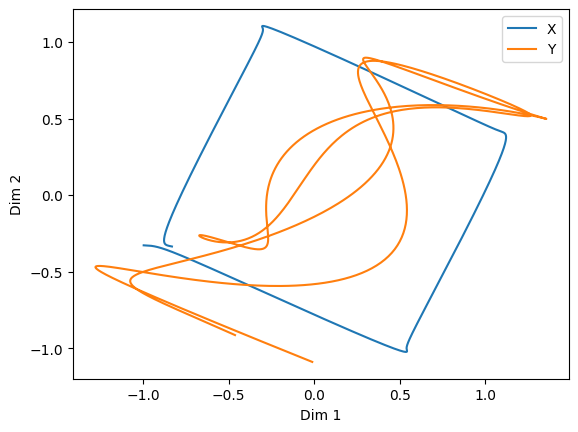

In [108]:
X = baseline_hs_no_noise
Y = 10*hs_no_noise[4]

plt.plot(X[:, 0], X[:, 1], label="X")
plt.plot(Y[:, 0], Y[:, 1], label="Y")
plt.legend()
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

In [ ]:
get_hs_for_dsa(twobitrnn, full_square, n_bits=twobitrnn.n_bits, burn_in=burn_in, smooth=smooth, sigma=sigma).shape

torch.Size([1350, 100])

In [ ]:
baseline_hs_no_noise.shape
dsa_model_test = DSA.dsa.DSA(baseline_hs_no_noise.unsqueeze(0), hs_no_noise[0].unsqueeze(0), rank=r, n_delays=p, score_method = "angular", device=device)
dsa_scores_test = dsa_model_test.fit_score()
print(dsa_scores_test)

0.0009134905994869769


In [ ]:
tensor1 = torch.rand(1600, 100)
tensor2 = torch.rand(1600, 100)
#dsa_model_test = DSA.dsa.DSA(baseline_hs_no_noise.unsqueeze(0), hs_no_noise[0].unsqueeze(0), rank=r, n_delays=p, score_method = "angular", device=device)
#dsa_scores_test = dsa_model_test.fit_score()

0.05729407072067261


In [ ]:
tensor2

tensor([[0.7893, 0.0108, 0.9501,  ..., 0.7314, 0.7191, 0.4906],
        [0.9328, 0.7525, 0.5597,  ..., 0.3902, 0.5080, 0.2599],
        [0.3814, 0.3946, 0.8992,  ..., 0.1059, 0.4933, 0.9206],
        ...,
        [0.6391, 0.1447, 0.6426,  ..., 0.9108, 0.3159, 0.5626],
        [0.4137, 0.9474, 0.4882,  ..., 0.7945, 0.0269, 0.4075],
        [0.2211, 0.2424, 0.4693,  ..., 0.9762, 0.2233, 0.8457]])

In [ ]:
torch.use_deterministic_algorithms(True)
dsa_scores_test = DSA.dsa.DSA(tensor1, [tensor2, tensor2], rank=5, n_delays=140, score_method = "angular", device=device, verbose=True).fit_score()
print(dsa_scores_test)

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
computing similarity between DMDs 0 and 1
Finished optimizing C
Finished optimizing C
[[0.61719948 0.62002748]]


In [ ]:
hs_no_noise[0].shape

torch.Size([1600, 100])

In [ ]:
device

device(type='cpu')

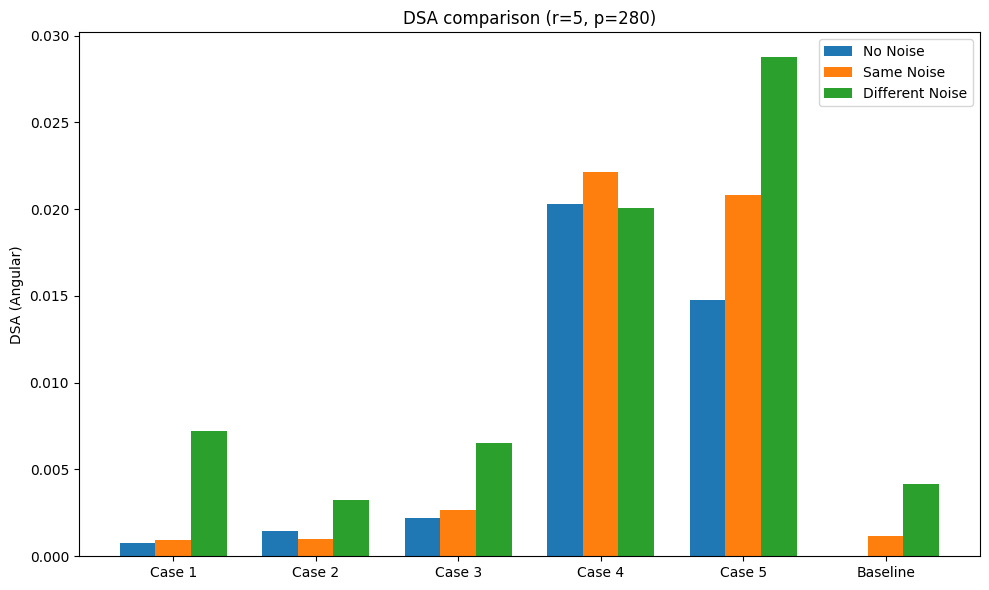

In [ ]:
bar_titles = ["Case 1", "Case 2", "Case 3", "Case 4", "Case 5", "Baseline"]
plot_title = "DSA comparison (r=5, p=280)"
plot_grouped_bars(dsa_scores_no_noise[0], dsa_scores_noise_1[0], dsa_scores_noise_2[0], bar_titles, plot_title)